In [76]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [77]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Kolmogorov-Smirnov Test
# The Kolmogorov-Smirnov test compares the data to a normal distribution.
from scipy.stats import kstest
from itertools import combinations
from scipy.stats import wilcoxon

from mne_connectivity import spectral_connectivity_epochs

In [78]:
process_epoch_path = "../data/processed_epochs.pkl"
with open(process_epoch_path, "rb") as f:
    epochs = pickle.load(f)

for key, value in epochs.items():
    print(key, value.shape)

pre (7, 49, 126001)
during (5, 49, 126001)
post (5, 49, 126001)
combine (17, 49, 126001)


In [79]:
# wpli_connectivity_permutation_analysis.pkl
# wpli_connectivity.pkl -> The difference is statistically significant
# dpli_connectivity.pkl -> -


features_path = "../wpli_connectivity.pkl"
with open(features_path, "rb") as f:
    features = pickle.load(f)

for key, value in features.items():
    print(key, value.shape)

pre (2401, 1)
during (2401, 1)
post (2401, 1)
combine (2401, 1)


In [80]:
def extract_lower_triangular(matrix):
    return matrix[np.tril_indices(matrix.shape[0], k=-1)]


def extract_stage_lower_triangular(connectivity):
    return extract_lower_triangular(connectivity.get_data("dense").squeeze())


# Step 3: Visualize the fit
def plot_fit(data, mean, std_dev, title: str = "pre"):
    # Plot the histogram of the data with Seaborn
    sns.histplot(
        data,
        bins=30,
        kde=False,
        stat="density",
        color="blue",
        edgecolor="black",
        alpha=0.6,
    )

    # Plot the PDF of the fitted normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std_dev)
    plt.plot(x, p, "k", linewidth=2)
    title = f"{title} - Fit results: mean = %.2f,  std dev = %.2f" % (mean, std_dev)
    plt.title(title)
    plt.show()


def ks_test(data):
    """
    Kolmogorov-Smirnov Test
    The Kolmogorov-Smirnov test compares the data to a normal
    distribution.

    Parameters
    ----------
    data : array-like
        The data to test for normality.
    """
    stat, p = kstest(data, "norm")
    print("Statistics=%.3f, p=%.3f" % (stat, p))
    if p > 0.05:
        print("Data is normally distributed (fail to reject H0)")
    else:
        print("Data is not normally distributed (reject H0)")


def perform_paired_ttest(sample1, sample2, alpha=0.05):
    t_statistic, p_value = stats.ttest_rel(sample1, sample2)

    return t_statistic, p_value

To determine if the distributions shown in the histograms are normally distributed, we can visually inspect the histograms and the overlaid density curves, as well as consider the mean and standard deviation provided.

First Image:

Mean = 0.47
Standard Deviation = 0.02
Visual Inspection: The histogram appears to have a skew to the right, indicating it might not be perfectly normally distributed. The density curve does not fit perfectly over the histogram, showing some deviation from normality.
Second Image:

Mean = 0.51
Standard Deviation = 0.02
Visual Inspection: The histogram looks more symmetric compared to the first one, and the density curve fits better over the histogram. This suggests that the distribution might be closer to a normal distribution.
Third Image:

Mean = 0.50
Standard Deviation = 0.02
Visual Inspection: Similar to the second image, this histogram appears quite symmetric, and the density curve fits well over the histogram. This indicates that the distribution is likely to be normally distributed.
Based on visual inspection:

The second and third images seem to be normally distributed.
The first image appears to have some skew and may not be normally distributed.
For a more accurate assessment, statistical tests like the Shapiro-Wilk test or the Kolmogorov-Smirnov test could be performed on the data to determine normality.

pre (1176,)
Estimated mean: 0.4746633935614686
Estimated standard deviation: 0.024689734188872534
Min: 0.42562185348178316
Max: 0.6135279109525987
Statistics=0.665, p=0.000
Data is not normally distributed (reject H0)


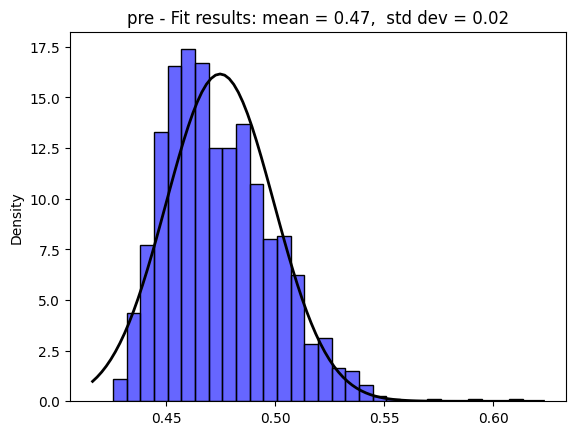

during (1176,)
Estimated mean: 0.5076599930864923
Estimated standard deviation: 0.016923735302602064
Min: 0.4631335599434668
Max: 0.593238843222245
Statistics=0.679, p=0.000
Data is not normally distributed (reject H0)


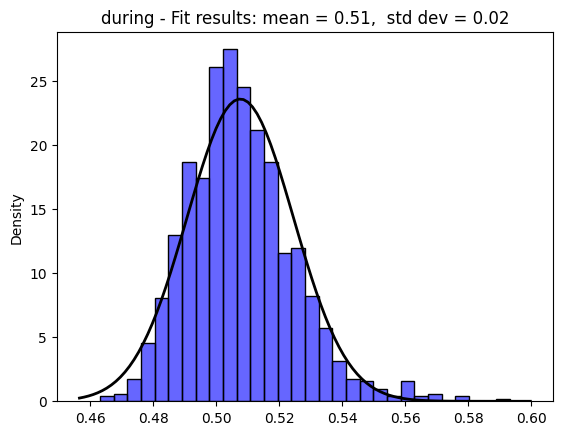

post (1176,)
Estimated mean: 0.49754808817911944
Estimated standard deviation: 0.017677384667243466
Min: 0.4561295629916423
Max: 0.584021771579198
Statistics=0.676, p=0.000
Data is not normally distributed (reject H0)


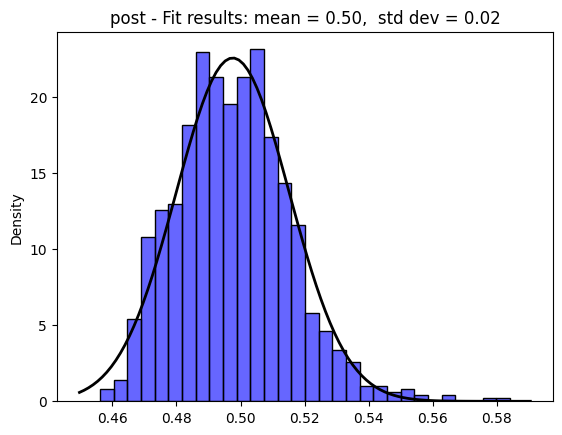

combine (1176,)
Estimated mean: 0.3268654221618337
Estimated standard deviation: 0.02763131779725232
Min: 0.2637037980874297
Max: 0.4404455146536653
Statistics=0.605, p=0.000
Data is not normally distributed (reject H0)


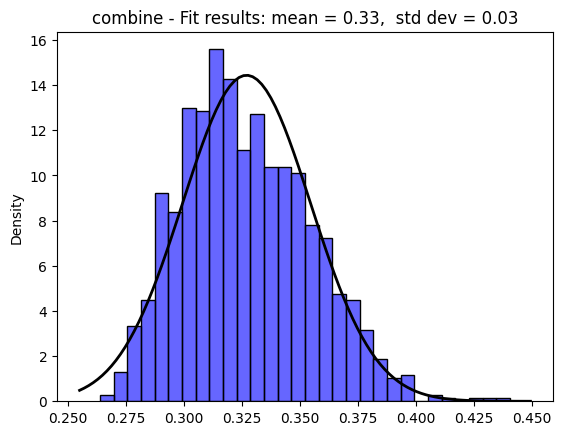

In [81]:
# check whether features are distributed normally or not
for key, value in features.items():
    data = extract_stage_lower_triangular(value)
    # filter non-zero values
    print(key, data.shape)
    mean, std = data.mean(), data.std()

    print(f"Estimated mean: {mean}")
    print(f"Estimated standard deviation: {std}")

    # print min and max
    print(f"Min: {data.min()}")
    print(f"Max: {data.max()}")

    ks_test(data)

    # Plot the fitted distribution
    plot_fit(data, mean, std, title=key)

In [82]:
# Calculate t-test between classes

alpha = 0.05

# calculate the correlation between the lower triangular matrices
correlations = {}
for stage1, stage2 in combinations(features.keys(), 2):
    print(f"\nComparing {stage1} and {stage2}:")
    t_statistic, p_value = perform_paired_ttest(
        extract_stage_lower_triangular(features[stage1]),
        extract_stage_lower_triangular(features[stage2]),
    )

    print("\nPaired Samples T-Test Results:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")

    if p_value < alpha:
        print(f"The difference is statistically significant (p < {alpha})")
    else:
        print(f"The difference is not statistically significant (p >= {alpha})")


Comparing pre and during:

Paired Samples T-Test Results:
T-statistic: -51.991121777681236
P-value: 6.027811091513613e-307
The difference is statistically significant (p < 0.05)

Comparing pre and post:

Paired Samples T-Test Results:
T-statistic: -37.636408921236225
P-value: 4.826926416337156e-204
The difference is statistically significant (p < 0.05)

Comparing pre and combine:

Paired Samples T-Test Results:
T-statistic: 424.4525413082307
P-value: 0.0
The difference is statistically significant (p < 0.05)

Comparing during and post:

Paired Samples T-Test Results:
T-statistic: 23.787608780142577
P-value: 2.0417362709370456e-102
The difference is statistically significant (p < 0.05)

Comparing during and combine:

Paired Samples T-Test Results:
T-statistic: 301.3436920793853
P-value: 0.0
The difference is statistically significant (p < 0.05)

Comparing post and combine:

Paired Samples T-Test Results:
T-statistic: 298.5569490769816
P-value: 0.0
The difference is statistically signif

In [83]:
# Calculate t-test between classes

alpha = 0.05

# calculate the correlation between the lower triangular matrices
correlations = {}
for stage1, stage2 in combinations(features.keys(), 2):
    print(f"\nComparing {stage1} and {stage2}:")
    t_statistic, p_value = wilcoxon(
        extract_stage_lower_triangular(features[stage1]),
        extract_stage_lower_triangular(features[stage2]),
    )

    print("\nPaired Samples T-Test Results:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")

    if p_value < alpha:
        print(f"The difference is statistically significant (p < {alpha})")
    else:
        print(f"The difference is not statistically significant (p >= {alpha})")


Comparing pre and during:

Paired Samples T-Test Results:
T-statistic: 18831.0
P-value: 1.3616590055863041e-173
The difference is statistically significant (p < 0.05)

Comparing pre and post:

Paired Samples T-Test Results:
T-statistic: 41988.0
P-value: 3.6044230110910713e-150
The difference is statistically significant (p < 0.05)

Comparing pre and combine:

Paired Samples T-Test Results:
T-statistic: 0.0
P-value: 6.658257303004654e-194
The difference is statistically significant (p < 0.05)

Comparing during and post:

Paired Samples T-Test Results:
T-statistic: 110922.0
P-value: 1.382048093713617e-90
The difference is statistically significant (p < 0.05)

Comparing during and combine:

Paired Samples T-Test Results:
T-statistic: 0.0
P-value: 6.658257303004654e-194
The difference is statistically significant (p < 0.05)

Comparing post and combine:

Paired Samples T-Test Results:
T-statistic: 0.0
P-value: 6.658257303004654e-194
The difference is statistically significant (p < 0.05)


In [86]:
# performing permutation test


def calculate_connectivity(epochs, sfreq, fmin, fmax, tmin, method: str = "wpli"):

    return spectral_connectivity_epochs(
        epochs,
        method=method,
        mode="multitaper",
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        faverage=True,  # Average connectivity scores for each frequency band. If True, the output freqs will be a list with arrays of the frequencies that were averaged.
        tmin=tmin,
        mt_adaptive=False,  # Use adaptive weights for multitaper
        n_jobs=4,
    )


def permutation_test(epochs, n_permutations=1000, alpha=0.05, *args, **kwargs):
    # Combine all data
    combined_data = epochs["combine"].copy()

    perm_stats_pre_post = []
    perm_stats_pre_during = []
    perm_stats_during_post = []

    for _ in range(n_permutations):
        np.random.shuffle(combined_data)
        shuffled_pre = combined_data[:7]
        shuffled_during = combined_data[7:12]
        shuffled_post = combined_data[12:]

        perm_wPLI_pre = extract_stage_lower_triangular(
            calculate_connectivity(shuffled_pre, *args, **kwargs)
        )
        perm_wPLI_during = extract_stage_lower_triangular(
            calculate_connectivity(shuffled_during, *args, **kwargs)
        )
        perm_wPLI_post = extract_stage_lower_triangular(
            calculate_connectivity(shuffled_post, *args, **kwargs)
        )

        perm_stats_pre_post.append(
            perform_paired_ttest(perm_wPLI_post.flatten(), perm_wPLI_pre.flatten())
        )
        perm_stats_pre_during.append(
            perform_paired_ttest(perm_wPLI_during.flatten(), perm_wPLI_pre.flatten())
        )
        perm_stats_during_post.append(
            perform_paired_ttest(perm_wPLI_post.flatten(), perm_wPLI_during.flatten())
        )

    # create a dictionary to store the results
    results = {
        "pre_post": perm_stats_pre_post,
        "pre_during": perm_stats_pre_during,
        "during_post": perm_stats_during_post,
    }

    return results

In [87]:
sfreq = 500
fmin = 8
fmax = 50
tmin = 0
method = "wpli"
n_permutation = 1

permutation_test(
    epochs=epochs,
    n_permutations=n_permutation,
    alpha=0.05,
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    tmin=tmin,
    method=method,
)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1176 connections
    using t=0.000s..252.000s for estimation (126001 points)
    frequencies: 8.0Hz..50.0Hz (10584 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epochs 1..4


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished


    computing cross-spectral density for epochs 5..7


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   41.2s finished


    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1176 connections
    using t=0.000s..252.000s for estimation (126001 points)
    frequencies: 8.0Hz..50.0Hz (10584 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epochs 1..4


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   58.5s remaining:   58.5s


    computing cross-spectral density for epochs 5..5


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   59.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1176 connections
    using t=0.000s..252.000s for estimation (126001 points)
    frequencies: 8.0Hz..50.0Hz (10584 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epochs 1..4


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   55.1s remaining:   55.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   56.5s finished


    computing cross-spectral density for epochs 5..5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


    assembling connectivity matrix
[Connectivity computation done]


{'pre_post': [(121.91086312954819, 0.0)],
 'pre_during': [(126.50428623229749, 0.0)],
 'during_post': [(-0.417172601580324, 0.676628370891784)]}